In [65]:
import sys
module_path='/home/DAHS2/Timellm/Replicate_for_P19/'
if module_path not in sys.path:
    sys.path.append(module_path)

from data_provider.data_factory import P19_DataLoader
import argparse

import pandas as pd
import numpy as np

args = argparse.Namespace(
        batch_size = 2000,
        split_num = 1,
        mode = 'Visualization',
        root_path = '/home/DAHS2/Timellm/Replicate_for_P19/',
        PT_dict_path = 'dataset/data/processed_data/PT_dict_list_6.npy',
        outcomes_path = 'dataset/data/processed_data/arr_outcomes_6.npy',
        num_workers = 0,
        data = 'P19',
        seq_len = 60,
        llm_layers=2,
        n_heads = 1,
        d_ff = 16,
        enc_in = 34,
        pred_len = 1,
        patch_len = 6,
        stride = 2,
        dropout = 0.1,
        llm_model = 'GPT2',
        llm_dim = '768',
        d_model = 16,
        prompt_domain = 'Sepsis',
        undersampling = False,
        upsampling = True
)

In [2]:
vis_data, vis_loader = P19_DataLoader(args, args.data, flag = 'Visualization')

In [3]:
x_enc, y, time, real_time,  demo = next(iter((vis_loader)))[0], next(iter((vis_loader)))[1], next(iter((vis_loader)))[2], next(iter((vis_loader)))[3], next(iter((vis_loader)))[4] 

In [4]:
x_enc[0]

tensor([[ -4.9528, -33.5764, -47.3678,  ...,  -1.7965,  -1.9348,  -1.8672],
        [ -0.4810,   0.9886,   0.4913,  ...,  -1.7965,  -1.9348,  -1.8672],
        [ -0.8875,   0.9886, -47.3678,  ...,  -1.7965,  -1.9348,  -1.8672],
        ...,
        [ -0.0000,  -0.0000,  -0.0000,  ...,  -0.0000,  -0.0000,  -0.0000],
        [ -0.0000,  -0.0000,  -0.0000,  ...,  -0.0000,  -0.0000,  -0.0000],
        [ -0.0000,  -0.0000,  -0.0000,  ...,  -0.0000,  -0.0000,  -0.0000]])

In [8]:
def getStats(P_tensor):
    N, T, F = P_tensor.shape
    Pf = P_tensor.transpose((2, 0, 1)).reshape(F, -1)
    mf = np.zeros((F, 1))
    stdf = np.ones((F, 1))
    eps = 1e-7
    for f in range(F):
        vals_f = Pf[f, :]
        vals_f = vals_f[vals_f > 0]
        mf[f] = np.mean(vals_f)
        stdf[f] = np.std(vals_f)
        stdf[f] = np.maximum(stdf[f], eps)
    return mf, stdf

def getStats_static(P_tensor, dataset='P12'):
    N, S = P_tensor.shape
    Ps = P_tensor.transpose((1, 0))
    ms = np.zeros((S, 1))
    ss = np.ones((S, 1))

    if dataset == 'P12':
        # ['Age' 'Gender=0' 'Gender=1' 'Height' 'ICUType=1' 'ICUType=2' 'ICUType=3' 'ICUType=4' 'Weight']
        bool_categorical = [0, 1, 1, 0, 1, 1, 1, 1, 0]
    elif dataset == 'P19':
        # ['Age' 'Gender' 'Unit1' 'Unit2' 'HospAdmTime' 'ICULOS']
        bool_categorical = [0, 1, 0, 0, 0, 0]
    elif dataset == 'eICU':
        # ['apacheadmissiondx' 'ethnicity' 'gender' 'admissionheight' 'admissionweight'] -> 399 dimensions
        bool_categorical = [1] * 397 + [0] * 2

    for s in range(S):
        if bool_categorical == 0:  # if not categorical
            vals_s = Ps[s, :]
            vals_s = vals_s[vals_s > 0]
            ms[s] = np.mean(vals_s)
            ss[s] = np.std(vals_s)
    return ms, ss

def mask_normalize_static(P_tensor, ms, ss):
    N, S = P_tensor.shape
    Ps = P_tensor.transpose((1, 0))

    # input normalization
    for s in range(S):
        Ps[s] = (Ps[s] - ms[s]) / (ss[s] + 1e-18)

    # set missing values to zero after normalization
    for s in range(S):
        idx_missing = np.where(Ps[s, :] <= 0)
        Ps[s, idx_missing] = 0

    # reshape back
    Pnorm_tensor = Ps.reshape((S, N)).transpose((1, 0))
    return Pnorm_tensor

def mask_normalize(P_tensor, mf, stdf, lengths):
    """ Normalize time series variables. Missing ones are set to zero after normalization. """
    N, T, F = P_tensor.shape

    # Initialize the mask based on lengths
    M = np.zeros((N, T, F))
    for i in range(N):
        length = lengths[i]  # 실제 체류한 길이
        M[i, :length, :] = 1  # 체류한 길이까지는 1로 설정

    # Normalize the time series variables
    Pf = P_tensor.transpose((2, 0, 1)).reshape(F, -1)
    M_3D = M.transpose((2, 0, 1)).reshape(F, -1)
    for f in range(F):
        Pf[f] = (Pf[f] - mf[f]) / (stdf[f] + 1e-18)
    Pf = Pf * M_3D  # Only apply normalization where M is 1 (valid data)

    # Reshape Pf back to original dimensions and add the mask M as the last feature
    Pnorm_tensor = Pf.reshape((F, N, T)).transpose((1, 2, 0))
    Pfinal_tensor = np.concatenate([Pnorm_tensor, M], axis=2)
    
    return Pfinal_tensor

def tensorize_normalize(P, y, mf, stdf, ms, ss):
    T, F = P[0]['arr'].shape
    D = len(P[0]['extended_static'])

    P_tensor = np.zeros((len(P), T, F))
    P_time = np.zeros((len(P), T, 1))
    P_static_tensor = np.zeros((len(P), D))
    lengths = np.zeros(len(P), dtype=int)  # 각 시퀀스의 실제 체류 길이를 저장할 배열

    for i in range(len(P)):
        P_tensor[i] = P[i]['arr']
        P_time[i] = P[i]['time']
        P_static_tensor[i] = P[i]['extended_static']
        lengths[i] = P[i]['length']  # 실제 체류한 길이를 저장

    P_tensor = mask_normalize(P_tensor, mf, stdf, lengths)  # lengths를 함께 전달
    P_tensor = torch.Tensor(P_tensor)

    P_time = torch.Tensor(P_time) / 60.0  # convert mins to hours
    P_static_tensor = mask_normalize_static(P_static_tensor, ms, ss)
    P_static_tensor = torch.Tensor(P_static_tensor)

    y_tensor = torch.Tensor(y[:, 0]).type(torch.LongTensor)
    return P_tensor, P_static_tensor, P_time, y_tensor

In [9]:
import warnings
import torch
warnings.filterwarnings('ignore')

In [10]:
split_path = args.root_path + 'dataset/data/splits/phy19_split' + str(args.split_num+1) + '_new.npy'
idx_train, idx_val, idx_test = np.load(split_path, allow_pickle=True)

In [11]:
Pdict_list = np.load(args.root_path + args.PT_dict_path, allow_pickle=True)
arr_outcomes = np.load(args.root_path + args.outcomes_path, allow_pickle=True)

Pdata = Pdict_list[idx_train]
Pdata_label = arr_outcomes[idx_train]

# length가 40 이상인 샘플들만 선택
valid_indices = [i for i in range(len(Pdata)) if Pdata[i]['length'] >= 40]

# 유효한 샘플들로 데이터와 라벨을 필터링
Pdata = Pdata[valid_indices]
Pdata_label = Pdata_label[valid_indices]

# 라벨 0과 라벨 1의 인덱스를 추출
label_0_indices = np.where(Pdata_label == 0)[0]
label_1_indices = np.where(Pdata_label == 1)[0]

# 각각의 샘플 개수와 max_samples 중 작은 값을 선택
num_label_0 = min(len(label_0_indices), 1000)
num_label_1 = min(len(label_1_indices), 1000)

# 라벨 0과 1에서 각각 최대 num_label_0, num_label_1 개수만 추출
selected_label_0_indices = label_0_indices[:num_label_0]
selected_label_1_indices = label_1_indices[:num_label_1]

# 최종 데이터셋 구성
selected_indices = np.concatenate((selected_label_0_indices, selected_label_1_indices))

Ptrain_final = Pdata[selected_indices]
Ptrain_label_final = Pdata_label[selected_indices]

T, F = Ptrain_final[0]['arr'].shape
D = len(Ptrain_final[0]['extended_static'])


Ptrain_tensor = np.zeros((len(Ptrain_final), T, F))
Ptrain_static_tensor = np.zeros((len(Ptrain_final), D))
Ptrain_length = np.zeros((len(Ptrain_final)))

for i in range(len(Ptrain_final)):
    Ptrain_tensor[i] = Ptrain_final[i]['arr']
    Ptrain_static_tensor[i] = Ptrain_final[i]['extended_static']
    Ptrain_length[i] = Ptrain_final[i]['length']

mf, stdf = getStats(Ptrain_tensor)
ms, ss = getStats_static(Ptrain_static_tensor, dataset='P19')

Ptrain_tensor, Ptrain_static_tensor, Ptrain_time_tensor, ytrain_tensor = tensorize_normalize(
    Ptrain_final, Ptrain_label_final, mf, stdf, ms, ss)

In [12]:
Ptrain_final[0]['length']

43

In [13]:
Ptrain_tensor[0][:43]

tensor([[ -4.9528, -33.5764, -47.3678,  ...,   1.0000,   1.0000,   1.0000],
        [ -0.4810,   0.9886,   0.4913,  ...,   1.0000,   1.0000,   1.0000],
        [ -0.8875,   0.9886, -47.3678,  ...,   1.0000,   1.0000,   1.0000],
        ...,
        [  0.2740,   0.9886, -47.3678,  ...,   1.0000,   1.0000,   1.0000],
        [ -0.0745,   0.9886,   1.3871,  ...,   1.0000,   1.0000,   1.0000],
        [ -0.6552,   0.9886, -47.3678,  ...,   1.0000,   1.0000,   1.0000]])

In [21]:
Ptrain_final[0]['arr'][:43, :8].shape

(43, 8)

In [23]:
num_patches

19

In [ ]:
feature_col = 

In [41]:
patches.shape

(21, 6, 8)

In [43]:
length

47

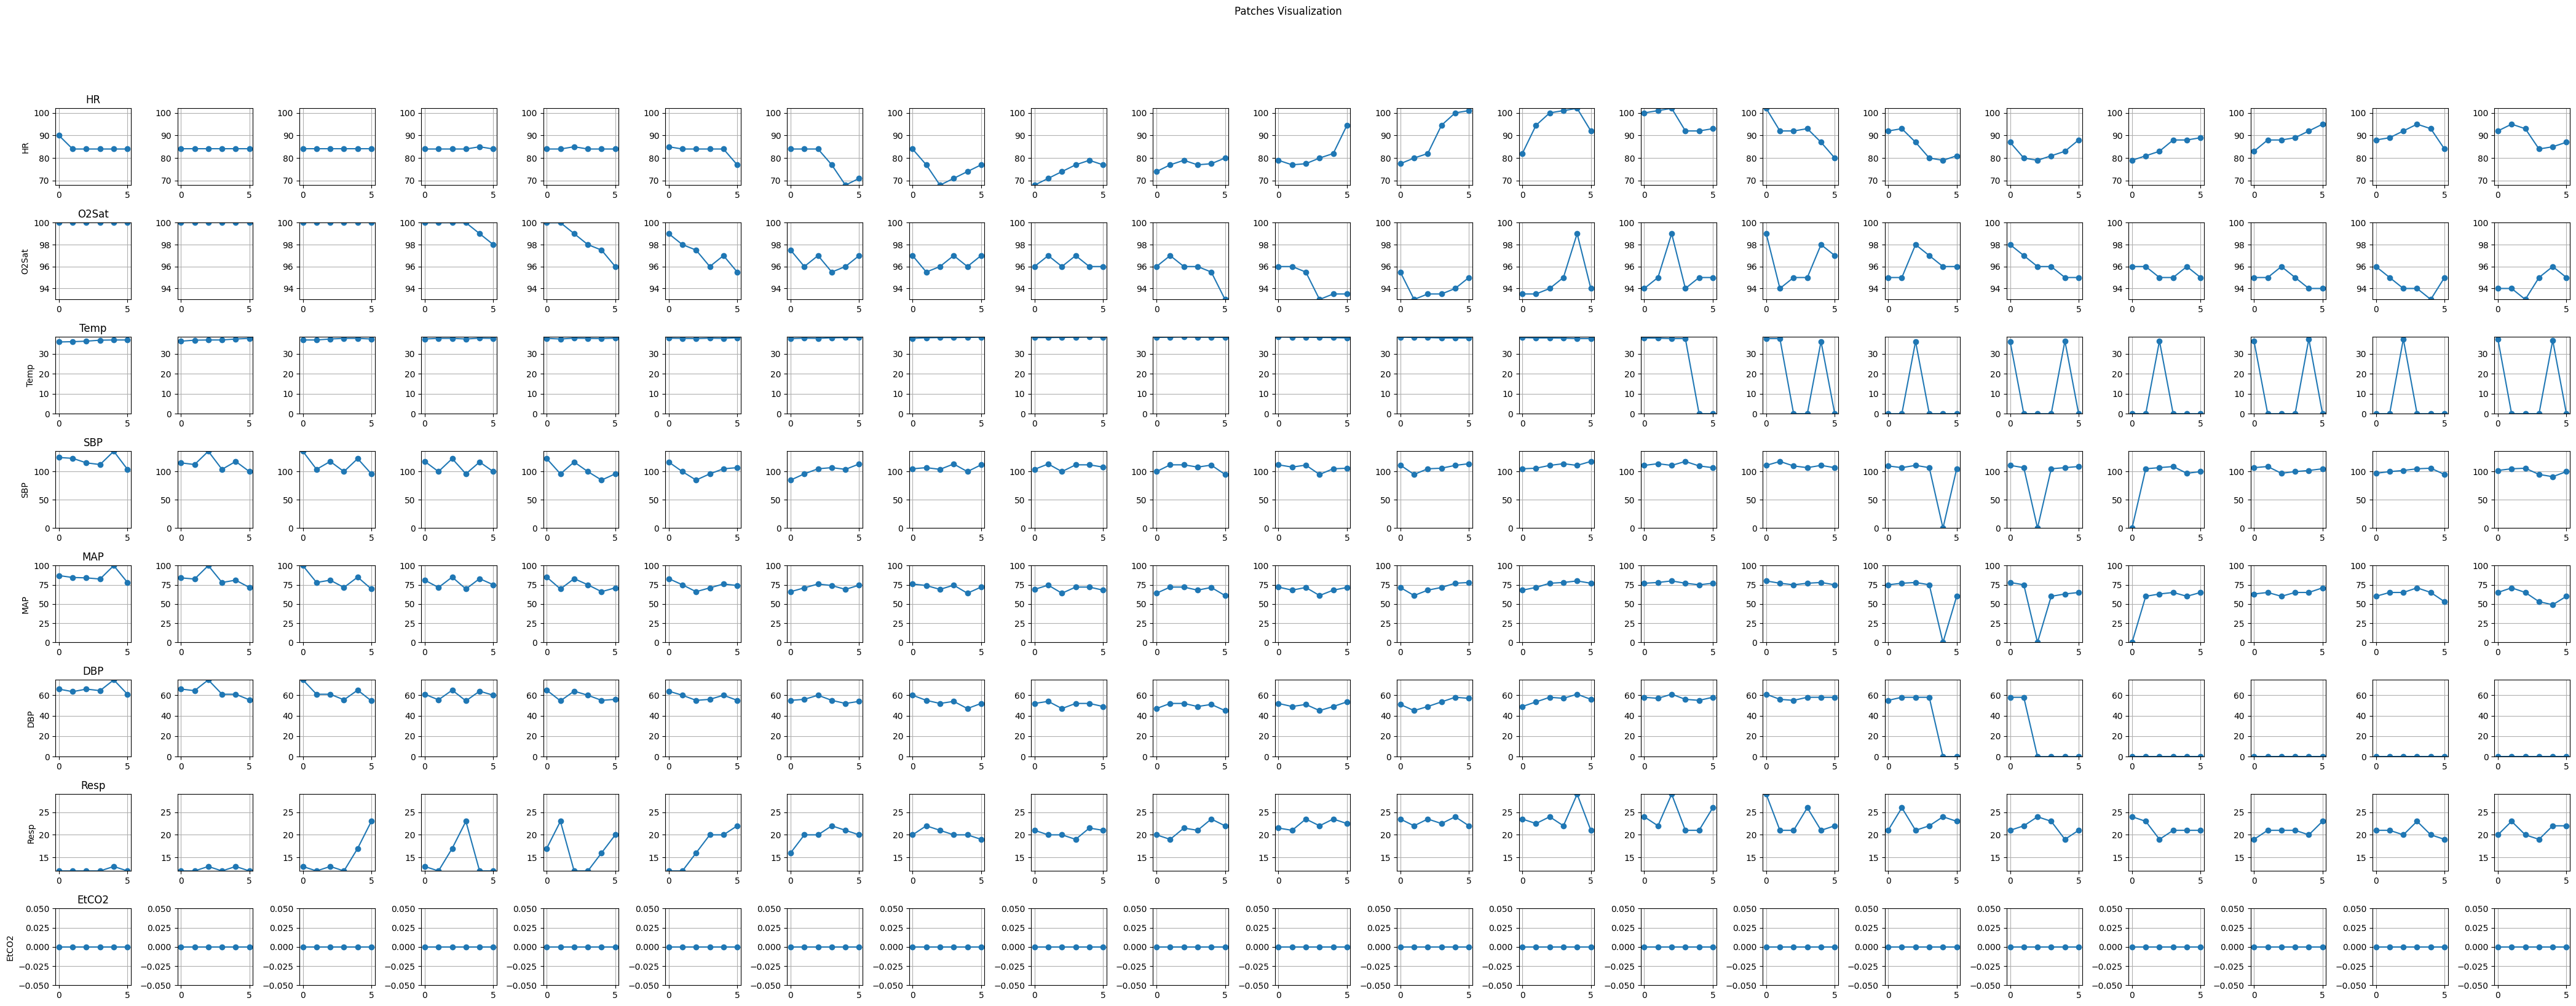

In [44]:
import matplotlib.pyplot as plt

length = Ptrain_final[1]['length']
data = Ptrain_final[1]['arr'][:length, :8]

# Feature names
feature_names = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
num_features = data.shape[1]
# Patch parameters
patch_len = 6
stride = 2

# 패치 공식 적용
seq_len = data.shape[0]
num_patches = int((seq_len - patch_len) / stride + 2) - 1

patches = []
for i in range(num_patches):
    start_idx = i * stride
    end_idx = start_idx + patch_len
    if end_idx <= seq_len:
        patch = data[start_idx:end_idx, :]
        patches.append(patch)

patches = np.array(patches)  # (number_of_patches, patch_len, num_features)

# 변수별 y축의 최솟값과 최댓값을 계산
y_min_per_feature = patches.min(axis=(0, 1))
y_max_per_feature = patches.max(axis=(0, 1))

# 서브플롯 배열을 생성할 때, (num_features, num_patches) 크기로 생성
fig, axes = plt.subplots(num_features, num_patches, figsize=(num_patches * 2, num_features * 2), sharey=False)

# 2차원 배열이 아닌 경우 처리 (예: num_features 또는 num_patches가 1일 때)
if num_features == 1:
    axes = np.expand_dims(axes, 0)
if num_patches == 1:
    axes = np.expand_dims(axes, 1)

# 가로 방향으로 각 feature를 시각화
for feature_idx in range(num_features):
    for patch_idx in range(num_patches):
        ax = axes[feature_idx, patch_idx]
        ax.plot(range(patch_len), patches[patch_idx, :, feature_idx], marker='o')
        ax.set_ylim(y_min_per_feature[feature_idx], y_max_per_feature[feature_idx])  # 각 변수별 y축 스케일 고정
        ax.grid(True)
        
        # 첫 번째 열에만 y축 레이블 추가
        if patch_idx == 0:
            ax.set_ylabel(feature_names[feature_idx])

    # 첫 번째 행의 각 feature의 첫 번째 서브플롯에 제목 설정
    axes[feature_idx, 0].set_title(feature_names[feature_idx])

plt.suptitle('Patches Visualization', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [82]:
weight_matrix = np.load('/home/DAHS2/Timellm/Replicate_for_P19/code/checkpoints/prototype_weight.npy')
score = np.load('/home/DAHS2/Timellm/Replicate_for_P19/code/checkpoints/Attention_scores.npy')
score.shape

(672, 8, 29, 10000)

In [71]:
score[0, 0, 11, :].shape

(10000,)

In [93]:
from transformers import LlamaConfig, LlamaModel, LlamaTokenizer, GPT2Config, GPT2Model, GPT2Tokenizer, BertConfig, \
    BertModel, BertTokenizer, AutoTokenizer, AutoModelForCausalLM
import transformers

transformers.logging.set_verbosity_error()

llama_config = GPT2Config.from_pretrained("openai-community/gpt2")
llama_config.num_hidden_layers = 16
llama_config.output_attentions = True
llama_config.output_hidden_states = True
try:
    llm_model = AutoModelForCausalLM.from_pretrained(
        # "/mnt/alps/modelhub/pretrained_model/LLaMA/7B_hf/",
        "openai-community/gpt2",
        trust_remote_code=True,
        # local_files_only=True,
        config=llama_config,
        # load_in_4bit=True,
        ignore_mismatched_sizes=True
    )
except EnvironmentError:  # downloads model from HF is not already done
    print("Local model files not found. Attempting to download...")
    llm_model = AutoModelForCausalLM.from_pretrained(
        # "/mnt/alps/modelhub/pretrained_model/LLaMA/7B_hf/",
        "openai-community/gpt2",
        trust_remote_code=True,
        # local_files_only=False,
        config=llama_config,
        # load_in_4bit=True
    )
try:
    tokenizer = AutoTokenizer.from_pretrained(
        # "/mnt/alps/modelhub/pretrained_model/LLaMA/7B_hf/tokenizer.model",
        "openai-community/gpt2",
        trust_remote_code=True,
        # local_files_only=True
    )
except EnvironmentError:  # downloads the tokenizer from HF if not already done
    print("Local tokenizer files not found. Atempting to download them..")
    tokenizer = AutoTokenizer.from_pretrained(
        # "/mnt/alps/modelhub/pretrained_model/LLaMA/7B_hf/tokenizer.model",
        "openai-community/gpt2",
        trust_remote_code=True,
        # local_files_only=False
    )
    
if tokenizer.eos_token:
    tokenizer.pad_token = tokenizer.eos_token
else:
    pad_token = '[PAD]'
    tokenizer.add_special_tokens({'pad_token': pad_token})
    tokenizer.pad_token = pad_token

In [87]:
topk_values, idx = torch.topk(torch.tensor(score[0, 0, 11, :]), 5, dim=0)

In [88]:
idx

tensor([8236, 1033, 4353, 3914, 8980])

In [80]:
score[0, 0, 11, 8236]

0.00012272029

In [84]:
# Let's analyze the first reduced dimension (index 0)
first_reduced_dimension_weights = weight_matrix[1033]  # Shape: (50257,)

# Find the top contributing tokens for the first reduced dimension
top_indices = first_reduced_dimension_weights.argsort()[-10:]  # Top 10 contributing tokens

# Sort top_indices by their corresponding weights in descending order
top_indices = top_indices[np.argsort(first_reduced_dimension_weights[top_indices])[::-1]]

# Decode the tokens to get their readable forms
top_tokens = [tokenizer.decode([i]) for i in top_indices]

print("Top contributing tokens for the first reduced dimension in descending order:", top_tokens)

Top contributing tokens for the first reduced dimension in descending order: [' Killer', ' Nob', ' perhaps', ' dome', ' comments', ' 1925', 'ria', ' assistants', ' Application', ' pleaded']


In [95]:
# 예를 들어, 지정한 단어 집합이 다음과 같다고 가정합니다.
custom_word_set = ['late', 'early', 'down', 'up', 'steady', 'short', 'long', 'peak', 'fluctuate', 'stabilize', 'irregular', 'consistent', 'sudden', 'gradual', 'missing', 'Not measured', 'nonlinear', 'linear', 'padding']

# GPT-2 토크나이저를 사용하여 각 단어의 토큰 인덱스를 찾습니다.
custom_word_indices = [tokenizer.encode(word, add_special_tokens=False)[0] for word in custom_word_set]

# 각 차원에서 custom word set의 가중치를 추출합니다.
custom_word_weights = weight_matrix[:, custom_word_indices]  # Shape: (1000, len(custom_word_set))

# 각 차원에서 custom word set의 가중치 합계를 계산합니다.
custom_word_weight_sums = np.sum(custom_word_weights, axis=1)  # Shape: (1000,)

# 가중치 합계를 기준으로 상위 5개 차원을 찾습니다.
top_dimensions = custom_word_weight_sums.argsort()[-5:][::-1]

print("Custom word set에 높은 가중치를 가지는 상위 10개의 차원:", top_dimensions)

Custom word set에 높은 가중치를 가지는 상위 10개의 차원: [4490  425 1461 2376 3755]


In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
sns.heatmap(custom_word_weights, cmap='viridis', cbar=True)

plt.title('Heatmap of Prototype and Word Set')
plt.xlabel('Word Set')
plt.ylabel('Prototypes')
plt.savefig('heatmap_large.png', dpi=300)  # 고해상도로 저장
plt.close()

In [139]:
custom_word_weights.shape

(10000, 19)

In [170]:
# 각 word set에 대해 가장 큰 값을 가지는 상위 10개의 프로토타입 인덱스를 추출
custom_word_set = ['late', 'early', 'down', 'up', 'steady', 'short', 'long', 'peak', 'fluctuate', 'stabilize', 'irregular', 'consistent', 'sudden', 'gradual', 'missing', 'Not measured', 'nonlinear', 'linear', 'padding']

# GPT-2 토크나이저를 사용하여 각 단어의 토큰 인덱스를 찾습니다.
custom_word_indices = [tokenizer.encode(word, add_special_tokens=False)[0] for word in custom_word_set]

custom_word_weights = weight_matrix[:, custom_word_indices]  # Shape: (1000, len(custom_word_set))

custom_word_weight_sums = np.sum(custom_word_weights, axis=1)
top_dimensions = custom_word_weight_sums.argsort()[-10:][::-1]

# 상위 10개의 프로토타입 추출
top_prototypes = custom_word_weights[top_dimensions]

# 히트맵 그리기
plt.figure(figsize=(10, 6))
sns.heatmap(top_prototypes, cmap='OrRd', cbar=False)

# plt.title('Top 10 Prototypes for Each Word Set')
plt.xlabel('Word Set 1')
plt.ylabel('Top Prototypes')
plt.savefig('wordset1.png', dpi=300)  # 고해상도로 저장
plt.close()

In [161]:
wordset_1 = ['late', 'early', 'down', 'up', 'steady', 'short', 'long', 'peak', 'fluctuate', 'stabilize', 'irregular', 'consistent', 'sudden', 'gradual', 'missing', 'Not measured', 'nonlinear', 'linear', 'padding']
wordset_2 = ['increase', 'decrease', 'plateau', 'oscillate', 'spike', 'trend', 'deviation', 'noise', 'seasonality', 'cycle', 'anomaly', 'drift', 'mean', 'variance', 'autocorrelation', 'lag', 'lead', 'outlier', 'periodicity']
wordset_3 = ['decay', 'forecast', 'interpolation', 'extrapolation', 'stationary', 'nonstationary', 'trend', 'deviation', 'noise', 'seasonality', 'cycle', 'anomaly', 'drift', 'mean', 'variance', 'autocorrelation', 'lag', 'lead', 'outlier']

In [162]:
# GPT-2 토크나이저를 사용하여 각 단어의 토큰 인덱스를 찾습니다.
custom_word_indices = [tokenizer.encode(word, add_special_tokens=False)[0] for word in wordset_2]

# 각 차원에서 custom word set의 가중치를 추출합니다.
custom_word_weights = weight_matrix[:, custom_word_indices]  # Shape: (1000, len(custom_word_set))

# 각 word set에 대해 가장 큰 값을 가지는 상위 10개의 프로토타입 인덱스를 추출
custom_word_weight_sums = np.sum(custom_word_weights, axis=1)
top_dimensions = custom_word_weight_sums.argsort()[-10:][::-1]

# 상위 10개의 프로토타입 추출
top_prototypes = custom_word_weights[top_dimensions]

# 히트맵 그리기
plt.figure(figsize=(10, 6))
sns.heatmap(top_prototypes, cmap='OrRd', cbar=False)

# plt.title('Top 10 Prototypes for Each Word Set')
plt.xlabel('Word Set 2')
plt.ylabel('Top Prototypes')
plt.savefig('wordset2.png', dpi=300)  # 고해상도로 저장
plt.close()

In [163]:
# GPT-2 토크나이저를 사용하여 각 단어의 토큰 인덱스를 찾습니다.
custom_word_indices = [tokenizer.encode(word, add_special_tokens=False)[0] for word in wordset_3]

# 각 차원에서 custom word set의 가중치를 추출합니다.
custom_word_weights = weight_matrix[:, custom_word_indices]  # Shape: (1000, len(custom_word_set))

# 각 word set에 대해 가장 큰 값을 가지는 상위 10개의 프로토타입 인덱스를 추출
custom_word_weight_sums = np.sum(custom_word_weights, axis=1)
top_dimensions = custom_word_weight_sums.argsort()[-10:][::-1]

# 상위 10개의 프로토타입 추출
top_prototypes = custom_word_weights[top_dimensions]

# 히트맵 그리기
plt.figure(figsize=(10, 6))
sns.heatmap(top_prototypes, cmap='OrRd', cbar=False)

# plt.title('Top 10 Prototypes for Each Word Set')
plt.xlabel('Word Set 3')
plt.ylabel('Top Prototypes')
plt.savefig('wordset3.png', dpi=300)  # 고해상도로 저장
plt.close()

In [180]:
custom_word_indices = [tokenizer.encode(word, add_special_tokens=False)[0] for word in wordset_1]
topk_values, idx = torch.topk(torch.tensor(score[0, 0, 11, :]), 3, dim=0)

In [181]:
idx

tensor([8236, 1033, 4353])

In [171]:
top_dimensions

array([4490,  425, 1461, 2376, 3755, 5352, 2323, 1696, 7926, 1000])

In [182]:
# Let's analyze the first reduced dimension (index 0)
first_reduced_dimension_weights = weight_matrix[8236]  # Shape: (50257,)

# Find the top contributing tokens for the first reduced dimension
top_indices = first_reduced_dimension_weights.argsort()[-30:]  # Top 10 contributing tokens

# Sort top_indices by their corresponding weights in descending order
top_indices = top_indices[np.argsort(first_reduced_dimension_weights[top_indices])[::-1]]

# Decode the tokens to get their readable forms
top_tokens = [tokenizer.decode([i]) for i in top_indices]

print("Top contributing tokens for the first reduced dimension in descending order:", top_tokens)

Top contributing tokens for the first reduced dimension in descending order: [' Foley', ' Klein', 'pkg', 'ril', ' 800', 'POR', ' regenerate', ' straps', ' intersect', ' appra', '=$', ' Hancock', '?', ' Action', ' Hebrew', ' stressed', 'Now', ' Wheels', ' poisoned', ' originated', 'wn', ' Jama', 'agues', ' Pittsburgh', 'ohn', 'ben', ' planners', ' undes', ' Citizenship', ' spurious']
